# Libraries

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

from nltk.corpus import stopwords 
#from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk.tokenize import RegexpTokenizer
import re
import pickle

#from wordcloud import WordCloud
#pd.set_option('display.max_colwidth', -1)

Web scrapping info

        .
        .
        .

After web scrapping we created one single data frame with columns 'price', 'locali', 'superficie', 'bagni', 'piano', 'description' and stored it as a .csv file for future usage. 

In [2]:
#Importing data into memory from the stored .csv file
data = pd.read_csv("data_houses.csv", sep='\t', encoding='utf-8')
data.columns

Index(['price', 'locali', 'superficie', 'bagni', 'piano', 'description'], dtype='object')

In [3]:
#The number of rows before cleaning
data.shape

(23203, 6)

In [4]:
#Checking null values of the dataset
data.isnull().sum()

price             1
locali          354
superficie       24
bagni           491
piano          3793
description    5045
dtype: int64

In [5]:
#Checking data types of the dataset
data.dtypes

price          object
locali         object
superficie     object
bagni          object
piano          object
description    object
dtype: object

In [6]:
data.loc[:,['price','locali','superficie','bagni','piano']].describe()

,price,locali,superficie,bagni,piano
count,23202,22849,23179,22712,19410
unique,2335,6,587,315,15
top,€ 199.000,3,90,1,1
freq,338,7177,962,10007,4236


In [7]:
data.piano.value_counts()

1      4236
2      3308
T      2891
3      2419
A      1652
4      1570
R      1008
5       924
6       463
S       381
7       350
8       134
9        32
11+      26
10       16
Name: piano, dtype: int64



After _analyzing_ the possible values of each attribute of the dataset we decided the following about the process of 
**cleaning** the dataset before making two separate datasets for clustering.
    
The data cleaning process:
    1. Remove nan values
    2. Attribute price should be converted to integer data type and '€' removed from the values
    3. In attribute locali remove rows where the value of locali is 5+ and convert attribute to integer data type
    4. Attribute superficie has some strange values because of the scrapping, like dates '14/02/19' '18/01/19' and all the values that don't make sense should be removed and the attribute should be converted to the integer data type
    5. For attribute piano replace T->0 and drop the rows with piano values A, R, S and 11+ cause they are ambiguous
    6. The values where the number of bathrooms(attribute bagni) are 1, 2 or 3 should be kept because they are the most common ones and other numbers are rare and therefore considered outliers(they are probably buildings_?). Moreover, rows with bagni values 3+ are eliminated cause value 3+ has ambigious meaning and it is not integer. 
    
The goal of the cleaning process was to eliminate all the ambiguous values and categorical values that can't have a meaningful numerical representation.

In [8]:
def clean_data(data):
    """
    Method that removes nan values and cleanes the data
    
    Input: dataframe
    Output: cleaned dataframe
    """
    
    #Remove rows where there aren't all values present
    data.dropna(inplace=True)

    #try to convert price to int and remove € 
    for i in data.index:
    #Becasuse of the web scrapping some prices had strings and text in this way we dealt with it if exception appears
    #'da' is because some prices were scrapped with the word 'da' before the price
        try:
            data.price[i]=int(data.price[i].replace('€', '').strip().replace('.','').replace('da',''))
    #before word class there is price we need
        except:
            try:
                data.price[i]=int(data.price[i].split('class')[0].replace('€', '').strip().replace('.',''))
           #in case of the bad scrapping value (e.g.just text) just drop those rows
            except:
                data.drop(i,inplace=True)
            
    #convert to int superficie and remove / and . in order to convert to int normally
    data.superficie=data.superficie.replace('[/]', '', regex=True).apply(lambda x: int(str(x).replace('.','')))
    
    #Drop rows where values of locali is 5+ and convert to int
    #strip is because of the web scrapping process which took whitespace
    data['locali']=data['locali'].apply(lambda x: x.strip())
    data.drop(data[ data['locali']=='5+'].index,inplace=True)


    #drop A, R, S and 11+  cause it is ambigious 
    data.drop(data[(data['piano']=='A') | (data['piano']=='R') | ( data['piano']=='S')| ( data['piano']=='11+')].index,inplace=True)
    #Attribute piano replace T->0 cause piano T is 'terro' which means it is floor 0
    data['piano']=np.where(data['piano']=='T', 0, data['piano'])     
    
    #remove whitespace from the values
    data.bagni=data.bagni.apply(lambda x: x.strip())
    #remove all the rows where the value of bagni is not 1,2,3...like 3+, cause other values don't have so many value counts
    data.drop(data[( data['bagni']!='1')&( data['bagni']!='2')&( data['bagni']!='3')].index,inplace=True)    

    #convert type of "price","locali","piano", "bagni" to numeric instead of object
    data[["price","locali","piano", "bagni"]] = data[["price","locali","piano", "bagni"]].apply(pd.to_numeric)
    
    #reset index so it starts from 0 to last row number not with scpapped number indices, but with consistent range
    data.reset_index(inplace=True)
    data.drop('index',axis=1,inplace=True)
    
    return data

In [9]:
cleaned_data=clean_data(data)

In [10]:
cleaned_data.index

RangeIndex(start=0, stop=10773, step=1)

In [11]:
cleaned_data.head(1)

,price,locali,superficie,bagni,piano,description
0,225000,2,50,1,1,papillo eur\r\r\n ...


In [12]:
#The number of rows after cleaning the dataset
#10773
cleaned_data.shape

(10773, 6)

In [13]:
#After cleaning the data(dropping rows where there aren't some values) there aren't any NaN values present
cleaned_data.isnull().sum()

price          0
locali         0
superficie     0
bagni          0
piano          0
description    0
dtype: int64

In [14]:
cleaned_data.dtypes

price           int64
locali          int64
superficie      int64
bagni           int64
piano           int64
description    object
dtype: object

# Datasets

Based on the single data frame we extracted using the web scrapping process we created the Description and the Information datasets

## Description dataset

(Description dataset)

    columns: description 

In [15]:
description_dataset=pd.DataFrame(cleaned_data.description)
pd.set_option('display.max_colwidth', -1)
description_dataset.head(1)

,description
0,"papillo eur\r\r\n PAPILLO EUR in elegante complesso residenziale rifinitissimo bilocale composto da soggiorno con angolo cottura, stanza da letto bagno e ampio balcone . con Rifiniture di pregio, pavimenti in parquet / grees, infissi in legno con vetro camera e porte in noce, grate nel salone, riscaldamento termoautonomo con caldaia centralizzata, aria condizionata, videocitofono, porta blindata, serramenti elettrici con chiusura centralizzata, antenna satellitare, isolamento termo acustico, pannelli solari e fotovoltaici , rilevatori elettronici di gas. Tutte le camere sono fornite di impianto antifurto, presa antenna satellitare e presa telefonica.div\r\r\ndiv\r\r\nORARI lunedi chiusidiv\r\r\n martedi 10:00-17:00div\r\r\n mercoledi 10:00-17:00div\r\r\ndivgiovedi 10:00-17:00div\r\r\ndivvenrdi 10:00-17:00div\r\r\ndivsabato 10:00-17:00div\r\r\n domenica 10:00-13:00\r\r\n"


## Information dataset

(Information dataset)

    columns: price, locali, superficie, bagni, piano

In [16]:
information_dataset=cleaned_data.drop(['description'],axis=1)
information_dataset.head(5)

,price,locali,superficie,bagni,piano
0,225000,2,50,1,1
1,339000,3,90,1,4
2,480000,4,125,2,4
3,135000,2,60,1,5
4,249000,2,75,1,1


In [17]:
#In this way we can reuse it and not repeat cleaning process every time we execute the notebook

In [18]:
#Save information and description datasets to two separate .csv files

In [19]:
information_dataset.to_csv('information_dataset.csv')

In [20]:
description_dataset.to_csv('description_dataset.csv')

Based on the description dataset we should make a dataframe that has _i_ collected announcements as indices and _j_ words like columns, where each value from the matrix represents tf_idf value _j-th_ word in _i-th_ announcement.

In [21]:
#Make vocabulary

In [22]:
def preprocessing_text(df):
    """
    Method that returns filtered words from the text input 
    
    Input: string(text)
    Output: list(bag of words)
    """  
    #remove upper cases
    df=df.lower()
   
    #replacing new line sign '\n' '\r' and 'div' from html with a whitespace ' '    
    df=df.replace('\\n',' ').replace('\\r',' ').replace('div',' ')
    
    #for removing stop words
    stop_words = set(stopwords.words('italian')) 
    #add html tags left from scrapping
    stop_words.add('div')
    stop_words.add('n')
    stop_words.add('b')

    #remove numbers
    df = re.sub("\d+", "", df)
    
    #for removing punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    
    #to tokenize the string
    word_tokens = tokenizer.tokenize(df)     

    #stemming
    #ps = PorterStemmer()
    snow_stem = SnowballStemmer('italian')
    filtered_words = [snow_stem.stem(w) for w in word_tokens if not w in stop_words] 

    return filtered_words

In [23]:
def build_vocabulary(df):
    """
    Method that creates vocabulary
    
    Input: dataframe
    Output: vocabulary list 
    """  
    #list for vocabulary 
    vocabulary_lst=[]
    #preprocessing description and get res->list of lists, where each list i a list of filtered preproccesed words 
    res=df.description.apply(lambda x: preprocessing_text(x))   
    
    #vocabulary_set is a set used for making vocabulary with unique words

    vocabulary_set = set(res[0]).union(*res[1:])

    
    #mapping words into integers
    vocabulary={} 
    for k,v in enumerate(vocabulary_set):
        vocabulary[v]= k
    return res,vocabulary

In [24]:
res,vocabulary=build_vocabulary(description_dataset)

In [25]:
len(res[0])

74

In [26]:
len(vocabulary)

14342

In [27]:
vocabulary

{'civilist': 0,
 'pandos': 1,
 'verdinois': 2,
 'assett': 3,
 'elettrific': 4,
 'osp': 5,
 'forlanin': 6,
 'drusill': 7,
 'sempion': 8,
 'galeazz': 9,
 'studiojoniosrl': 10,
 'peperin': 11,
 'buoninsegn': 12,
 'orar': 13,
 'salient': 14,
 'fossombon': 15,
 'requis': 16,
 'caratter': 17,
 'begon': 18,
 'apartment': 19,
 'istitutoimmobiliareital': 20,
 'night': 21,
 'rilocal': 22,
 'staderin': 23,
 'produttr': 24,
 'sorround': 25,
 'rc': 26,
 'risorseimmobiliariagency': 27,
 'opac': 28,
 'trattas': 29,
 'salott': 30,
 'settim': 31,
 'montemignai': 32,
 'copertur': 33,
 'fines': 34,
 'comprendent': 35,
 'langell': 36,
 'ricezion': 37,
 'rustruttur': 38,
 'fogazzar': 39,
 'ariosissim': 40,
 'torald': 41,
 'mompe': 42,
 'buonam': 43,
 'anchess': 44,
 'agenziam': 45,
 'pontefic': 46,
 'seven': 47,
 'situazion': 48,
 'aggregation': 49,
 'appartamen': 50,
 'sicuram': 51,
 'bu': 52,
 'pint': 53,
 'sq': 54,
 'inamov': 55,
 'gress': 56,
 'dimension': 57,
 'funzionar': 58,
 'montasol': 59,
 'brune

In [28]:
#Saving vocabulary as a dictionary into a "vocabulary.p" (pickle) file

#21370 what else should we eliminate from the words??
pickle.dump(vocabulary, open("vocabulary.p", "wb"))

In [29]:
#To load it into memory from file
vocabulary = pickle.load(open("vocabulary.p", "rb"))

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
every row is a separate house(which is considered as a separate document)

In [30]:
####NEED TO change and finish it in ORDER TO CALCULATE TF_IDF VALUES 
def compute_inverted_idx(res,vocabulary):
    """
    method that computes an inverted index
    
    input: res(list of lists), vocabulary(dictionary of all unique words, key=term, value=term_id)
    output: inverted_idx(dictionary, key=term_id, value=list of document_ids(rows)) 
    """
    #initialize defaultdict for making an inverted index
    inverted_idx = defaultdict(list)
    #in every document look for every word and assign document id to the words which belong to it
    for idx,lst in enumerate(res):
        lst=((pd.Series(lst).value_counts())/len(lst)).sort_index()

        #lst=set(lst)
        for i,tf in enumerate(lst):
            inverted_idx[lst.index[i]].append((idx,tf))
    return inverted_idx

In [31]:
inverted_idx=compute_inverted_idx(res,vocabulary)

In [32]:
len(inverted_idx)
#dictionary->key=term_id,  value= (document_id,tf_value)

14342

In [33]:
len(inverted_idx['plus'])

12

In [34]:
inverted_idx['plus']

[(942, 0.004366812227074236),
 (1377, 0.0025),
 (1774, 0.008403361344537815),
 (2975, 0.00411522633744856),
 (4448, 0.0036363636363636364),
 (4983, 0.0040650406504065045),
 (5028, 0.0078125),
 (5219, 0.0036363636363636364),
 (6420, 0.013888888888888888),
 (6659, 0.005235602094240838),
 (7597, 0.007936507936507936),
 (10345, 0.006578947368421052)]

In [35]:
#Saving inverted_idx as a dictionary into a "inverted_idx.p" (pickle) file
pickle.dump(inverted_idx, open("inverted_idx.p", "wb"))

In [36]:
#dictionary->key=doc_id,word,  value=tfidf---. sequentially for each word in vocab
tf_idf_dic={}
total_num_docs=description_dataset.shape[0]

    #dictionary->key=term_id, value= (document_id,tf_value)
for term,tup_pair in inverted_idx.items():
    for doc_id,tf_value in tup_pair:
        tf_idf_dic[(doc_id,term)]= np.log(total_num_docs/len(inverted_idx[term]))*tf_value

In [37]:
#Saving inverted_idx as a dictionary into a "inverted_idx.p" (pickle) file

pickle.dump(tf_idf_dic, open("tf_idf_dic.p", "wb"))

In [38]:
len(tf_idf_dic)

863552

In [39]:
tf_idf_dic[942,'plus']

0.02969384992622791

In [58]:
description_dataset=pd.DataFrame(columns=list(vocabulary.keys()))
for row in range(data.shape[0]):
    temp_row_values=[]
    for word in vocabulary:
        try:
            temp_row_values.append(tf_idf_dic[(doc_id,word)])
        except:
            temp_row_values.append(0)
    description_dataset[row]=temp_row_values

MemoryError: 

In [40]:
description_dataset.to_csv('description_dataset.csv')

In [41]:
#TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
#IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

def calculate_tf_idf(description_dataset,inverted_idx,vocabulary):
    """
    method that calculates tf-idf values
     
    input:  inverted_idx(dictionary, key=term_id, value=list of document_ids)
            vocabulary(dictionary of all unique words, key=term, value=term_id)
    output: tf_idf_dic(dictionary of tf_idf_values for all rows(docs), key=tuple(term,doc_id), value=tf_idf value)
    """ 
    
    return tf_idf_dic

In [42]:
#To load it into memory from file
inverted_idx = pickle.load(open("inverted_idx.p", "rb"))

# Clustering

This step consists in _clustering the house announcements_ using **K-means++** and choosing the **optimal** number of clusters using the **Elbow-Method**.

In [43]:
information_dataset=pd.read_csv('information_dataset.csv')

In [44]:
#should we normalize?

In [45]:
# Information dataset clustering

In [46]:
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Text(0.5,1,'Elbow curve')

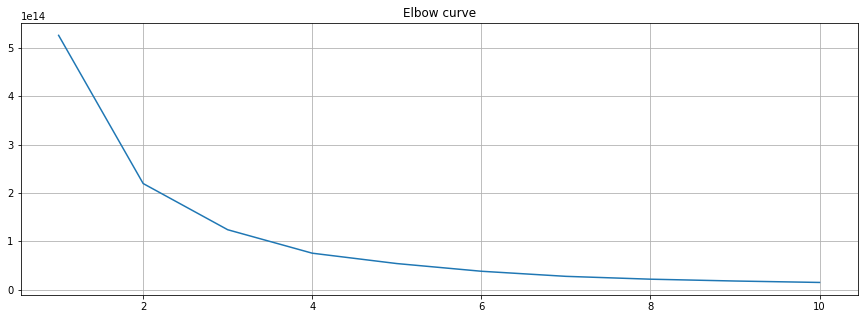

In [47]:
X=information_dataset.loc[:,['price','locali','superficie','bagni','piano']]
distorsions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,init='k-means++')
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), distorsions)
plt.grid(True)
plt.title('Elbow curve')
# Inertia: Sum of distances of samples to their closest cluster center

We chose blabla clusters:
Becausee

In [48]:
k=3
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [49]:
#centroids are:
kmeans.cluster_centers_

array([[5.12316100e+05, 3.83788774e+00, 1.24613368e+02, 1.84711965e+00,
        2.47525849e+00],
       [2.21033802e+05, 2.76065277e+00, 4.62876829e+02, 1.28726849e+00,
        2.03794845e+00],
       [1.13150727e+06, 4.28779070e+00, 1.66063953e+02, 2.22093023e+00,
        2.65116279e+00]])

In [50]:
information_dataset.columns

Index(['Unnamed: 0', 'price', 'locali', 'superficie', 'bagni', 'piano'], dtype='object')

In [51]:
cluster_representatives=pd.DataFrame(kmeans.cluster_centers_, columns= information_dataset.columns[1:])
cluster_representatives

,price,locali,superficie,bagni,piano
0,5.123161e+05,3.837888,124.613368,1.847120,2.475258
1,2.210338e+05,2.760653,462.876829,1.287268,2.037948
2,1.131507e+06,4.287791,166.063953,2.220930,2.651163


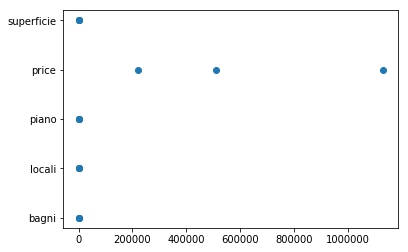

In [52]:
a=cluster_representatives.melt()
b=a.value
b1=a.variable
plt.plot(b,b1,'o')

In [53]:
kmeans.cluster_centers_.shape[0]
labels=kmeans.labels_
centers = np.array(kmeans.cluster_centers_)

In [54]:
centers

array([[5.12316100e+05, 3.83788774e+00, 1.24613368e+02, 1.84711965e+00,
        2.47525849e+00],
       [2.21033802e+05, 2.76065277e+00, 4.62876829e+02, 1.28726849e+00,
        2.03794845e+00],
       [1.13150727e+06, 4.28779070e+00, 1.66063953e+02, 2.22093023e+00,
        2.65116279e+00]])

In [55]:
#price centroids
centers[:,0]

array([ 512316.10044314,  221033.80158011, 1131507.26744186])

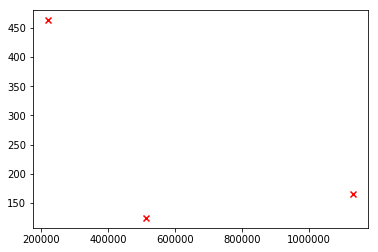

In [56]:
number_of_clusters=kmeans.cluster_centers_.shape[0]

#centroidi klastera


#Centroid's visualization
#for price and superficie
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,2], marker="x", color='r')

In [57]:
# Description dataset clustering